In [1]:
import tensorflow as tf

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.__version__

'2.9.1'

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        key = cv2.waitKey(20)
        if key == 27: # exit on ESC
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
draw_landmarks(frame, results)

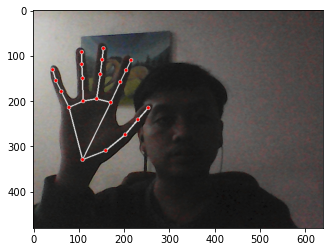

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [10]:
len(results.right_hand_landmarks.landmark)

21

In [9]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

# 4. Setup Folders for Collection

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA') 

# Actions that we try to detect
actions = np.array(['saya', 'kamu', 'ingin', 'sudah', 'mengembalikan', 'meminjam', 'mencari', 'buku', 'terima kasih'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [14]:
for action in actions: 
#     dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [15]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [16]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [10]:
label_map

{'saya': 0,
 'kamu': 1,
 'ingin': 2,
 'sudah': 3,
 'mengembalikan': 4,
 'meminjam': 5,
 'mencari': 6,
 'buku': 7,
 'terima kasih': 8}

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [12]:
np.array(sequences).shape

(405, 30, 126)

In [35]:
np.array(labels).shape

(405,)

In [36]:
X = np.array(sequences)

In [37]:
X.shape

(405, 30, 126)

In [38]:
y = to_categorical(labels).astype(int)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
y_test.shape

(41, 9)

# Build and Train LSTM Neural Network

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [20]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [14]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2, input_shape=(30,)))
model.add(Dense(actions.shape[0], activation='softmax'))

In [15]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
12/12 [==============================] - 8s 66ms/step - loss: 2.2010 - categorical_accuracy: 0.0879
Epoch 2/1000
12/12 [==============================] - 1s 69ms/step - loss: 2.1601 - categorical_accuracy: 0.1374
Epoch 3/1000
12/12 [==============================] - 1s 64ms/step - loss: 2.1169 - categorical_accuracy: 0.2225
Epoch 4/1000
12/12 [==============================] - 1s 65ms/step - loss: 2.0851 - categorical_accuracy: 0.2335
Epoch 5/1000
12/12 [==============================] - 1s 67ms/step - loss: 2.0513 - categorical_accuracy: 0.2445
Epoch 6/1000
12/12 [==============================] - 1s 74ms/step - loss: 2.0113 - categorical_accuracy: 0.2747
Epoch 7/1000
12/12 [==============================] - 1s 73ms/step - loss: 1.9931 - categorical_accuracy: 0.2253
Epoch 8/1000
12/12 [==============================] - 1s 70ms/step - loss: 1.9577 - categorical_accuracy: 0.2088
Epoch 9/1000
12/12 [==============================] - 1s 69ms/step - loss: 1.9434 - categorical_

12/12 [==============================] - 1s 71ms/step - loss: 0.5379 - categorical_accuracy: 0.8489
Epoch 144/1000
12/12 [==============================] - 1s 69ms/step - loss: 0.6903 - categorical_accuracy: 0.7940
Epoch 145/1000
12/12 [==============================] - 1s 70ms/step - loss: 0.4032 - categorical_accuracy: 0.9121
Epoch 146/1000
12/12 [==============================] - 1s 69ms/step - loss: 0.3952 - categorical_accuracy: 0.9121
Epoch 147/1000
12/12 [==============================] - 1s 70ms/step - loss: 0.4180 - categorical_accuracy: 0.9011
Epoch 148/1000
12/12 [==============================] - 1s 69ms/step - loss: 0.3884 - categorical_accuracy: 0.9148
Epoch 149/1000
12/12 [==============================] - 1s 68ms/step - loss: 0.6857 - categorical_accuracy: 0.7637
Epoch 150/1000
12/12 [==============================] - 1s 68ms/step - loss: 0.3982 - categorical_accuracy: 0.9038
Epoch 151/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.6137 - categoric

12/12 [==============================] - 1s 68ms/step - loss: 0.1246 - categorical_accuracy: 0.9725
Epoch 286/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0910 - categorical_accuracy: 0.9918
Epoch 287/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.4674 - categorical_accuracy: 0.8736
Epoch 288/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.1118 - categorical_accuracy: 0.9808
Epoch 289/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.3576 - categorical_accuracy: 0.8764
Epoch 290/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.1104 - categorical_accuracy: 0.9863
Epoch 291/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.1026 - categorical_accuracy: 0.9808
Epoch 292/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0910 - categorical_accuracy: 0.9890
Epoch 293/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.0918 - categoric

12/12 [==============================] - 1s 67ms/step - loss: 0.0231 - categorical_accuracy: 1.0000
Epoch 428/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.0256 - categorical_accuracy: 0.9973
Epoch 429/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.0269 - categorical_accuracy: 0.9973
Epoch 430/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0243 - categorical_accuracy: 0.9973
Epoch 431/1000
12/12 [==============================] - 1s 69ms/step - loss: 0.0245 - categorical_accuracy: 0.9973
Epoch 432/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.0269 - categorical_accuracy: 1.0000
Epoch 433/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0228 - categorical_accuracy: 1.0000
Epoch 434/1000
12/12 [==============================] - 1s 66ms/step - loss: 0.0250 - categorical_accuracy: 0.9973
Epoch 435/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0245 - categoric

12/12 [==============================] - 1s 77ms/step - loss: 0.0120 - categorical_accuracy: 1.0000
Epoch 570/1000
12/12 [==============================] - 1s 79ms/step - loss: 0.0122 - categorical_accuracy: 1.0000
Epoch 571/1000
12/12 [==============================] - 1s 78ms/step - loss: 0.0147 - categorical_accuracy: 1.0000
Epoch 572/1000
12/12 [==============================] - 1s 78ms/step - loss: 0.0124 - categorical_accuracy: 1.0000
Epoch 573/1000
12/12 [==============================] - 1s 78ms/step - loss: 0.0130 - categorical_accuracy: 1.0000
Epoch 574/1000
12/12 [==============================] - 1s 82ms/step - loss: 0.0111 - categorical_accuracy: 1.0000
Epoch 575/1000
12/12 [==============================] - 1s 76ms/step - loss: 0.0122 - categorical_accuracy: 1.0000
Epoch 576/1000
12/12 [==============================] - 1s 81ms/step - loss: 0.0108 - categorical_accuracy: 1.0000
Epoch 577/1000
12/12 [==============================] - 1s 81ms/step - loss: 0.0117 - categoric

12/12 [==============================] - 1s 69ms/step - loss: 0.0071 - categorical_accuracy: 1.0000
Epoch 712/1000
12/12 [==============================] - 1s 68ms/step - loss: 0.0076 - categorical_accuracy: 1.0000
Epoch 713/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0072 - categorical_accuracy: 1.0000
Epoch 714/1000
12/12 [==============================] - 1s 68ms/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 715/1000
12/12 [==============================] - 1s 69ms/step - loss: 0.0067 - categorical_accuracy: 1.0000
Epoch 716/1000
12/12 [==============================] - 1s 69ms/step - loss: 0.0084 - categorical_accuracy: 1.0000
Epoch 717/1000
12/12 [==============================] - 1s 70ms/step - loss: 0.0079 - categorical_accuracy: 1.0000
Epoch 718/1000
12/12 [==============================] - 1s 70ms/step - loss: 0.0077 - categorical_accuracy: 1.0000
Epoch 719/1000
12/12 [==============================] - 1s 74ms/step - loss: 0.0071 - categoric

12/12 [==============================] - 1s 71ms/step - loss: 0.0060 - categorical_accuracy: 1.0000
Epoch 854/1000
12/12 [==============================] - 1s 71ms/step - loss: 0.0065 - categorical_accuracy: 1.0000
Epoch 855/1000
12/12 [==============================] - 1s 70ms/step - loss: 0.0069 - categorical_accuracy: 1.0000
Epoch 856/1000
12/12 [==============================] - 1s 70ms/step - loss: 0.0057 - categorical_accuracy: 1.0000
Epoch 857/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0056 - categorical_accuracy: 1.0000
Epoch 858/1000
12/12 [==============================] - 1s 68ms/step - loss: 0.0059 - categorical_accuracy: 1.0000
Epoch 859/1000
12/12 [==============================] - 1s 73ms/step - loss: 0.0062 - categorical_accuracy: 1.0000
Epoch 860/1000
12/12 [==============================] - 1s 71ms/step - loss: 0.0058 - categorical_accuracy: 1.0000
Epoch 861/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0061 - categoric

12/12 [==============================] - 1s 68ms/step - loss: 0.0060 - categorical_accuracy: 1.0000
Epoch 996/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0048 - categorical_accuracy: 1.0000
Epoch 997/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0044 - categorical_accuracy: 1.0000
Epoch 998/1000
12/12 [==============================] - 1s 68ms/step - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 999/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0045 - categorical_accuracy: 1.0000
Epoch 1000/1000
12/12 [==============================] - 1s 67ms/step - loss: 0.0052 - categorical_accuracy: 1.0000


In [101]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 32)                20608     
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 9)                

# 8. Make Predictions

In [25]:
res = model.predict(X_test)

2/2 [==============================] - 2s 19ms/step


In [26]:
res.shape

(41, 9)

In [27]:
actions[np.argmax(res[5])]

'kamu'

In [28]:
actions[np.argmax(y_test[5])]

'kamu'

# 9. Save Weights

In [29]:
model.save('action_new_again_SGD.h5')

In [39]:
del model

In [42]:
# model = Sequential()

In [16]:
model.load_weights('action_new_again_SGD.h5')

In [17]:
model

# 10. Evaluation using Confusion Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [31]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 16ms/step


In [32]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [33]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[36,  0],
        [ 0,  5]],

       [[34,  0],
        [ 0,  7]],

       [[38,  0],
        [ 0,  3]],

       [[37,  0],
        [ 0,  4]],

       [[38,  0],
        [ 0,  3]],

       [[35,  0],
        [ 0,  6]],

       [[38,  0],
        [ 0,  3]],

       [[36,  0],
        [ 0,  5]],

       [[36,  0],
        [ 0,  5]]], dtype=int64)

In [34]:
accuracy_score(ytrue, yhat)

1.0

In [35]:
from sklearn.metrics import classification_report

print(classification_report(yhat, ytrue))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [50]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string])
  plt.show()

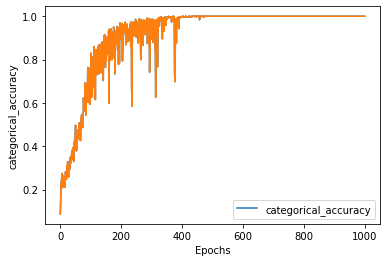

In [51]:
plot_graphs(history, 'categorical_accuracy')

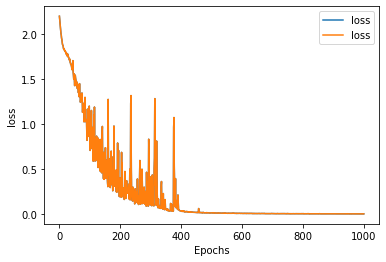

In [38]:
plot_graphs(history,'loss')

# 11. Test in Real Time

In [18]:
from gtts import gTTS
from pydub import AudioSegment
import subprocess
AudioSegment.converter = "C:/Users/user/ffmpeg-2022-05-23/bin/ffmpeg.exe"

In [19]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.4
deteksi = 0

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        if (frame is not None):
            
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)
            
            if deteksi == 1:
                if (results.right_hand_landmarks != None) and (len(results.right_hand_landmarks.landmark) == 21):
                    # 2. Prediction logic
                    keypoints = extract_keypoints(results)
                    sequence.append(keypoints)
                    sequence = sequence[-30:]

                    if len(sequence) == 30:
                        res = model.predict(np.expand_dims(sequence, axis=0))[0]
                        print(actions[np.argmax(res)])
                        predictions.append(np.argmax(res))


                    #3. Viz logic
                        if np.unique(predictions[-10:])[0]==np.argmax(res): 
                            if res[np.argmax(res)] > threshold: 

                                if len(sentence) > 0: 
                                    if actions[np.argmax(res)] != sentence[-1]:
                                        sentence.append(actions[np.argmax(res)])
                                else:
                                    sentence.append(actions[np.argmax(res)])

                        if len(sentence) > 4: 
                            sentence = sentence[-4:]


                    cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
                    cv2.putText(image, ' '.join(sentence), (3,30), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Break gracefully
        key = cv2.waitKey(10)
        if key == 32: # toggle deteksi
            if deteksi == 0:
                deteksi = 1
            else:
                deteksi = 0
                if sentence:
                    description = ' '.join(sentence)
                    tts = gTTS(description, lang='id')
                    tts.save('tts.mp3')
                    tts = AudioSegment.from_mp3("tts.mp3")
                    subprocess.call(["ffplay", "-nodisp", "-autoexit", "tts.mp3"])
        elif key == 27:
            break
    cap.release()
    cv2.destroyAllWindows()
    os.remove("tts.mp3")

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
saya
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==========================

1/1 [==============================] - 0s 36ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 43ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 43ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
buku
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==========================

In [ ]:
sentence